# Image classification

_Programming PyTorch for Deep Learning: Creating and Deploying Deep Learning Applications_

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [2]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [3]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

In [4]:
train_data_path = "../project1/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)

In [5]:
val_data_path = "../project1/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

In [6]:
test_data_path = "../project1/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms, is_valid_file=check_image) 

In [7]:
batch_size=64

In [8]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True) 

## Build a convolutional neural network

**_based on Alexnet_**

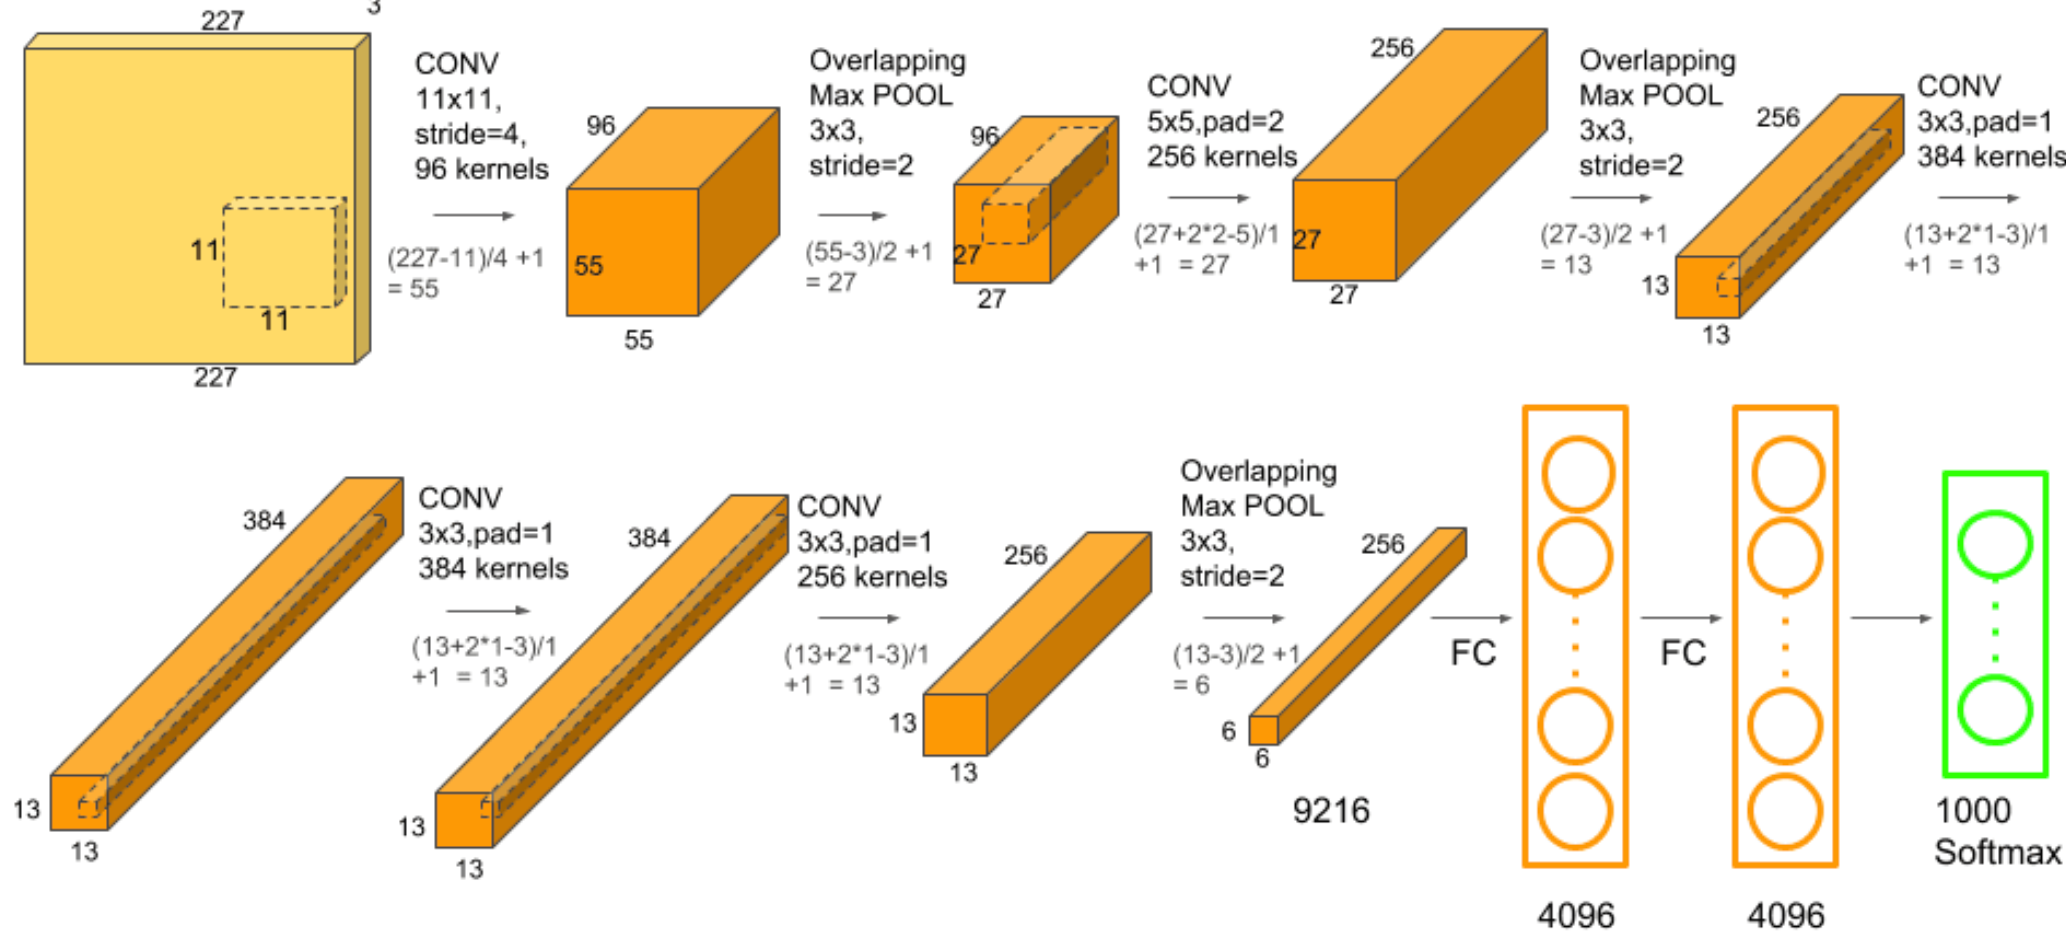

In [9]:
class CNN(nn.Module):

    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
cnn = CNN()

## optimizer

In [11]:
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

cnn.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): L

## Training 

In [13]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [14]:
train(cnn, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=10, device=device)

Epoch: 1, Training Loss: 1.52, Validation Loss: 0.58, accuracy = 0.76
Epoch: 2, Training Loss: 0.59, Validation Loss: 0.66, accuracy = 0.61
Epoch: 3, Training Loss: 0.50, Validation Loss: 0.37, accuracy = 0.82
Epoch: 4, Training Loss: 0.48, Validation Loss: 0.37, accuracy = 0.81
Epoch: 5, Training Loss: 0.42, Validation Loss: 0.28, accuracy = 0.88
Epoch: 6, Training Loss: 0.48, Validation Loss: 0.64, accuracy = 0.53
Epoch: 7, Training Loss: 0.45, Validation Loss: 0.36, accuracy = 0.83
Epoch: 8, Training Loss: 0.47, Validation Loss: 0.37, accuracy = 0.84
Epoch: 9, Training Loss: 0.43, Validation Loss: 0.50, accuracy = 0.67
Epoch: 10, Training Loss: 0.40, Validation Loss: 0.35, accuracy = 0.83
